In [1]:
from scipy.optimize import leastsq
import numpy as np
import matplotlib.pyplot as plt 

In [36]:
def dist(p1,p2):
    cant1 = np.abs(p1[0] - p2[0])
    cant2 = np.abs(p1[1] - p2[1])
    dist = np.sqrt((cant1**2) + (cant2**2))
    return dist

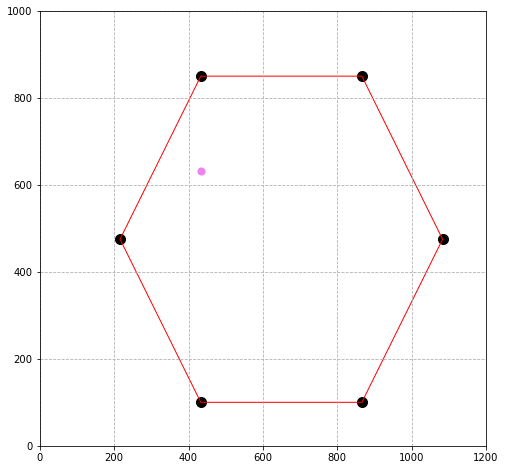

In [174]:
points = [[433,100],[866,100],[1083,475],[866,850],[433,850],[216,475]]
pointsx,pointsy = [433,866,1083,866,433,216] , [100,100,475,850,850,475]
randx,randy = np.random.uniform(433,866),np.random.uniform(100,850)


distancias = []
for i in range(len(points)):
    distancias.append(dist([randx,randy],points[i]))
    

plt.figure(figsize=(8,8))
polygon = plt.Polygon(points,fill=None,edgecolor='r')
plt.gca().add_patch(polygon)
plt.xlim(0,1200)
plt.ylim(0,1000)
plt.scatter(randx,randy,s = 50,c='violet')
plt.scatter(pointsx,pointsy,s = 100,c = 'black')
plt.grid(linestyle='--')
plt.show()




Chequeo las distancias entre los verrtices

In [175]:
for i in range(len(points)):
    if i == len(points)-1:
        print(dist(points[0],points[len(points)-1]))
    if i < len(points)-1:
        print(dist(points[i],points[i+1]))

433.0
433.2597373400856
433.2597373400856
433.0
433.2597373400856
433.2597373400856


In [176]:
distancias

[532.5965045038317,
 685.4745698920027,
 667.4037258673915,
 483.2014801537527,
 217.410489774186,
 269.37886652594193]